# FIAP IA para Dev
## Tech Challenge Fase 01 - Modelo


### Importação e Configuração

In [25]:
import warnings

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, balanced_accuracy_score, roc_auc_score, \
    classification_report, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

### Carregamento e Exploração dos Dados

In [26]:
# Carregando o dataset
df = pd.read_csv('../data/lung_cancer_prediction_dataset.csv')
df.head()

,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,China,1400,80,Male,Yes,30,29,No,No,...,Low,Yes,No,Poor,No,NaN,Developing,690000,2.44,0.0
1,1,Iran,84,53,Male,No,0,0,Yes,No,...,Low,Yes,No,Poor,No,NaN,Developing,27000,2.10,0.0
2,2,Mexico,128,47,Male,Yes,12,6,Yes,No,...,Medium,No,No,Poor,Yes,NaN,Developing,28000,1.11,0.0
3,3,Indonesia,273,39,Female,No,0,0,No,Yes,...,Low,No,No,Poor,No,NaN,Developing,40000,0.75,0.0
4,4,South Africa,59,44,Female,No,0,0,Yes,No,...,Medium,Yes,No,Poor,No,NaN,Developing,15000,2.44,0.0


In [27]:
# Verificando as informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220632 entries, 0 to 220631
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           220632 non-null  int64  
 1   Country                      220632 non-null  object 
 2   Population_Size              220632 non-null  int64  
 3   Age                          220632 non-null  int64  
 4   Gender                       220632 non-null  object 
 5   Smoker                       220632 non-null  object 
 6   Years_of_Smoking             220632 non-null  int64  
 7   Cigarettes_per_Day           220632 non-null  int64  
 8   Passive_Smoker               220632 non-null  object 
 9   Family_History               220632 non-null  object 
 10  Lung_Cancer_Diagnosis        220632 non-null  object 
 11  Cancer_Stage                 8961 non-null    object 
 12  Survival_Years               220632 non-null  int64  
 13 

In [ ]:
# Verificando a distribuição da target, como podemos ver a uma grande incidencia de "No" que pode indicar um desbalanceamento nas classes (muito mais casos "No" que "Yes"). 
# Isso é crucial pois modelos tendem a ficar enviesados para a classe majoritária.
df['Lung_Cancer_Diagnosis'].value_counts(normalize=True)

Lung_Cancer_Diagnosis
No     0.959385
Yes    0.040615
Name: proportion, dtype: float64

In [ ]:
# Obtendo as colunas categóricas, para posterior transformação
df.select_dtypes(include=['object']).columns

Index(['Country', 'Gender', 'Smoker', 'Passive_Smoker', 'Family_History',
       'Lung_Cancer_Diagnosis', 'Cancer_Stage', 'Adenocarcinoma_Type',
       'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution',
       'Healthcare_Access', 'Early_Detection', 'Treatment_Type',
       'Developed_or_Developing'],
      dtype='object')

In [ ]:
# Verificando as colunas nulas, como as nulas são Cancer_Stage e Treatment_Type
df.isna().sum()

ID                                  0
Country                             0
Population_Size                     0
Age                                 0
Gender                              0
Smoker                              0
Years_of_Smoking                    0
Cigarettes_per_Day                  0
Passive_Smoker                      0
Family_History                      0
Lung_Cancer_Diagnosis               0
Cancer_Stage                   211671
Survival_Years                      0
Adenocarcinoma_Type                 0
Air_Pollution_Exposure              0
Occupational_Exposure               0
Indoor_Pollution                    0
Healthcare_Access                   0
Early_Detection                     0
Treatment_Type                 213968
Developed_or_Developing             0
Annual_Lung_Cancer_Deaths           0
Lung_Cancer_Prevalence_Rate         0
Mortality_Rate                      0
dtype: int64

### Pré-processamento

In [ ]:
# Substitui valores nulos por "Unknown" em vez de deletar registros, preservando o tamanho do dataset.
df.fillna('Unknown', inplace=True)

In [ ]:
# Normalizando as colunas categoricas, como há um grande numero de colunas e as colunas categoricas nao passam de 4 possíveis valores, 
# utilizamos o LabelEncoder no lugar do OneHot para não criar mais colunas
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

df.head()

,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,2,1400,80,1,1,30,29,0,0,...,1,1,0,1,0,3,1,690000,2.44,0.0
1,1,10,84,53,1,0,0,0,1,0,...,1,1,0,1,0,3,1,27000,2.10,0.0
2,2,13,128,47,1,1,12,6,1,0,...,2,0,0,1,1,3,1,28000,1.11,0.0
3,3,9,273,39,0,0,0,0,0,1,...,1,0,0,1,0,3,1,40000,0.75,0.0
4,4,19,59,44,0,0,0,0,1,0,...,2,1,0,1,0,3,1,15000,2.44,0.0


In [ ]:
# Verificando se sobrou alguma coluna com valores nulos
df.isna().sum()

ID                             0
Country                        0
Population_Size                0
Age                            0
Gender                         0
Smoker                         0
Years_of_Smoking               0
Cigarettes_per_Day             0
Passive_Smoker                 0
Family_History                 0
Lung_Cancer_Diagnosis          0
Cancer_Stage                   0
Survival_Years                 0
Adenocarcinoma_Type            0
Air_Pollution_Exposure         0
Occupational_Exposure          0
Indoor_Pollution               0
Healthcare_Access              0
Early_Detection                0
Treatment_Type                 0
Developed_or_Developing        0
Annual_Lung_Cancer_Deaths      0
Lung_Cancer_Prevalence_Rate    0
Mortality_Rate                 0
dtype: int64

In [ ]:
# Definindo as features, baseado na analise exploratoria 
features = ['Population_Size', 'Country', 'Age', 'Gender', 'Smoker', 'Years_of_Smoking', 'Cigarettes_per_Day'
    , 'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis', 'Air_Pollution_Exposure',
            'Occupational_Exposure', 'Indoor_Pollution']

In [35]:
# Verificando registros duplicados
df[features].duplicated().sum()

np.int64(67737)

In [ ]:
# Realizando a normalização com o MinMaxScaler colocando os valores entre 0 ou 1 para manter a escala, uma variavel com valores maiores dominaria as outras

mm_scaler = MinMaxScaler()

df['Population_Size'] = mm_scaler.fit_transform(df[['Population_Size']])
df['Age'] = mm_scaler.fit_transform(df[['Age']])
df['Years_of_Smoking'] = mm_scaler.fit_transform(df[['Years_of_Smoking']])
df['Cigarettes_per_Day'] = mm_scaler.fit_transform(df[['Cigarettes_per_Day']])
df['Annual_Lung_Cancer_Deaths'] = mm_scaler.fit_transform(df[['Annual_Lung_Cancer_Deaths']])
df['Lung_Cancer_Prevalence_Rate'] = mm_scaler.fit_transform(df[['Lung_Cancer_Prevalence_Rate']])


In [ ]:
# Excluindo registros com valores duplicados e criando um dataset limpo
df_clean = df[features].drop_duplicates()
df_processed = df_clean.copy()

df_processed

,Population_Size,Country,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution
0,1.000000,2,0.923077,1,1,0.75,0.966667,0,0,0,1,1,0
1,0.022288,10,0.507692,1,0,0.00,0.000000,1,0,0,1,1,0
2,0.054978,13,0.415385,1,1,0.30,0.200000,1,0,0,2,0,0
3,0.162704,9,0.292308,0,0,0.00,0.000000,0,1,0,1,0,0
4,0.003715,19,0.369231,0,0,0.00,0.000000,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220624,0.118128,1,0.553846,0,0,0.00,0.000000,1,0,0,1,0,1
220625,0.030461,3,0.646154,0,1,0.20,0.833333,1,0,0,0,0,1
220626,0.011887,20,0.246154,0,1,1.00,0.866667,1,0,0,0,0,0
220627,0.011887,20,0.538462,1,1,0.10,0.333333,0,1,0,2,0,0


### Análise de correlação da variável target

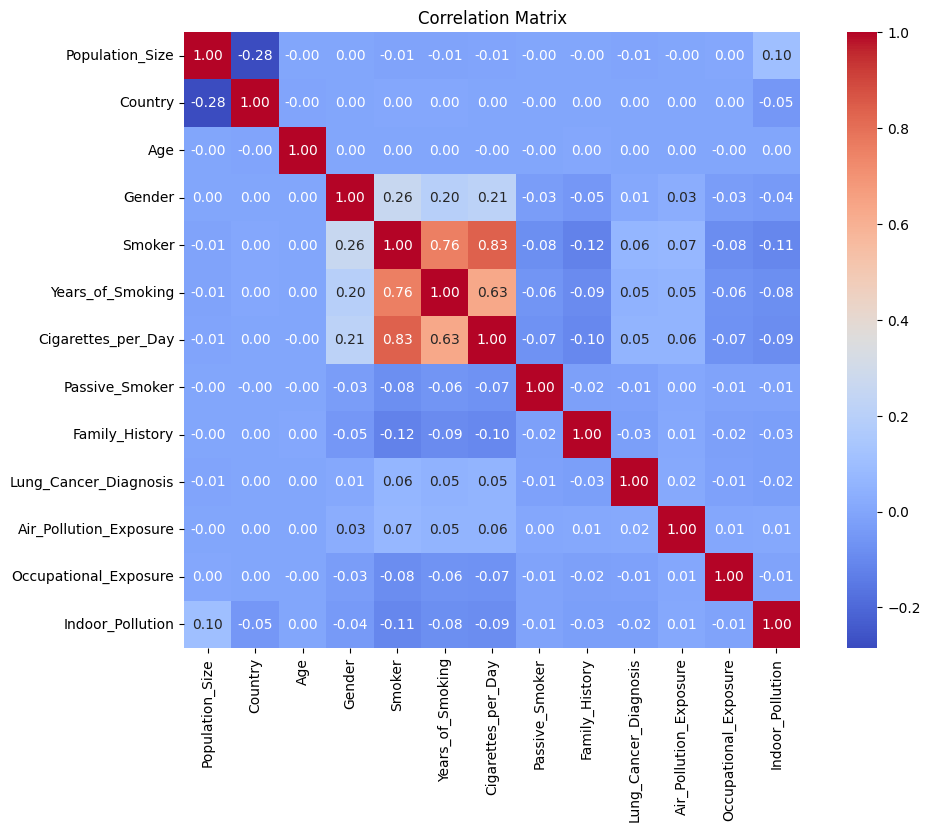

In [ ]:
# Verificando correlação das variaveis, 
import seaborn as sns

correlation_matrix = df_processed.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [39]:
# Verificando correlacao com a target
target_correlations = correlation_matrix['Lung_Cancer_Diagnosis'].abs().sort_values(ascending=False)
print(target_correlations)

Lung_Cancer_Diagnosis     1.000000
Smoker                    0.063362
Cigarettes_per_Day        0.052988
Years_of_Smoking          0.047823
Family_History            0.027244
Indoor_Pollution          0.023985
Air_Pollution_Exposure    0.015622
Passive_Smoker            0.014880
Occupational_Exposure     0.013914
Gender                    0.009839
Population_Size           0.005743
Age                       0.001253
Country                   0.001016
Name: Lung_Cancer_Diagnosis, dtype: float64


### Preparação para Modelagem

In [40]:
y = df_processed['Lung_Cancer_Diagnosis']
X = df_processed.drop(columns=['Lung_Cancer_Diagnosis'])

In [41]:
print(f"Shape das features: {X.shape}")
print(f"Shape do target: {y.shape}")
print(f"Distribuição do target: {y.value_counts().to_dict()}")

Shape das features: (152895, 12)
Shape do target: (152895,)
Distribuição do target: {0: 144011, 1: 8884}


In [42]:
# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [43]:
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Distribuição no treino: {y_train.value_counts().to_dict()}")
print(f"Distribuição no teste: {y_test.value_counts().to_dict()}")

Tamanho do conjunto de treino: (122316, 12)
Tamanho do conjunto de teste: (30579, 12)
Distribuição no treino: {0: 115209, 1: 7107}
Distribuição no teste: {0: 28802, 1: 1777}


### Balanceamento dos Dados

Como há muita incidencia de "No" isso pode levar o modelo a um overfitting com essa predição, por isso iremos realizar o balanceamos de dados e porteriormente definir qual dele usar com base na acurácia

In [ ]:
# Reduz a classe majoritaria para balancear o dataset. O sampling_strategy=0.5 significa que a classe minoritária terá 50% do tamanho da majoritaria.
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.5)
x_train_rus, y_train_rus = rus.fit_resample(X, y)

In [ ]:
# Aumenta a classe minoritaria criando exemplos sinteticos. Ajuda o modelo a aprender melhor padrões da classe menos frequente.
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(shrinkage=0.1)

x_train_ros, y_train_ros = ros.fit_resample(X, y)

### Modelagem e Avaliação

Testa 3 algoritmos diferentes com validação cruzada (5-fold) para ter uma estimativa mais confiável da performance. Cada algoritmo tem características diferentes:

KNN: Simples, baseado em similaridade
Random Forest: Robusto, ensemble de árvores
Decision Tree: Interpretável, fácil de entende

In [46]:
def evaluate_models(x_data, y_data):
    models = {
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    results = {}
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        cv_results = cross_val_score(model, x_data, y_data, cv=kfold, scoring='accuracy')
        results[name] = {
            'mean_accuracy': cv_results.mean(),
            'std_accuracy': cv_results.std(),
            'data': (x_data, y_data)
        }
        print(f"{name}: {cv_results.mean():.4f} (+/- {cv_results.std() * 2:.4f})")
    return results

In [ ]:
# Comparando a performance dos modelos com diferentes estrategias de balanceamento para escolher a melhor abordagem
print("Avaliando Resultados:")

print("Original:")
results_original = evaluate_models(X_train, y_train)
print("\n")
print("Com Amostragem Subamostrada")
results_rus = evaluate_models(x_train_rus, y_train_rus)
print("\n")
print("Com Amostragem Sobreamostrada")
results_ros = evaluate_models(x_train_ros, y_train_ros)


Avaliando Resultados:
Original:
KNN: 0.9398 (+/- 0.0032)
Random Forest: 0.9311 (+/- 0.0037)
Decision Tree: 0.8737 (+/- 0.0050)


Com Amostragem Subamostrada
KNN: 0.6086 (+/- 0.0055)
Random Forest: 0.6179 (+/- 0.0120)
Decision Tree: 0.5535 (+/- 0.0076)


Com Amostragem Sobreamostrada
KNN: 0.7643 (+/- 0.0028)
Random Forest: 0.9466 (+/- 0.0012)
Decision Tree: 0.9304 (+/- 0.0009)


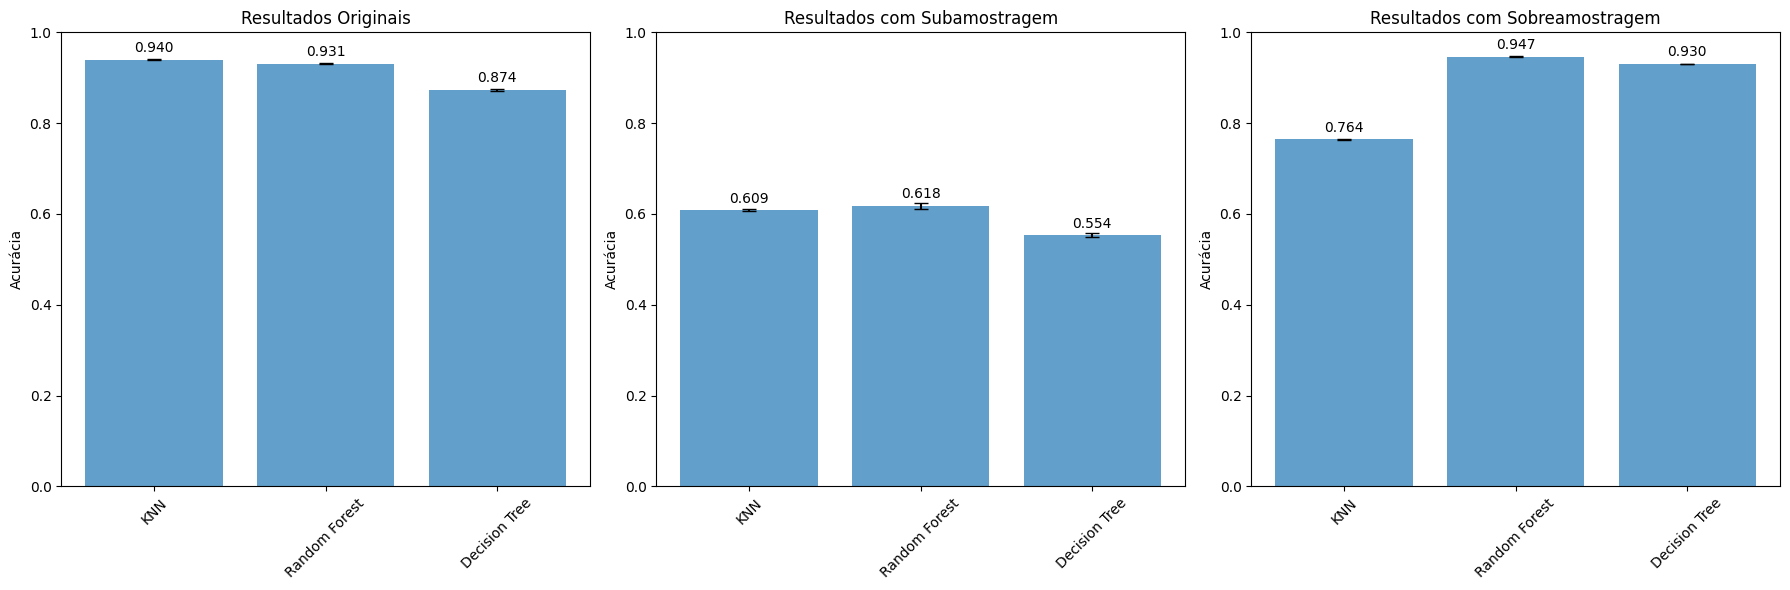

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


def plot_cv_results(results, title, ax):
    models = list(results.keys())
    means = [results[model]['mean_accuracy'] for model in models]
    stds = [results[model]['std_accuracy'] for model in models]

    bars = ax.bar(models, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel('Acurácia')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom')


plot_cv_results(results_original, 'Resultados Originais', axes[0])
plot_cv_results(results_rus, 'Resultados com Subamostragem', axes[1])
plot_cv_results(results_ros, 'Resultados com Sobreamostragem', axes[2])

plt.tight_layout()
plt.show()

In [ ]:
# Escolhendo o melhore modelo com base na analise acima
traning_model_name = 'rf'
X_best_train, y_best_train = x_train_ros, y_train_ros

### Otimização

In [50]:
models_params = {
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'data': X_best_train
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [6, 8],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'cosine']
        },
        'data': X_best_train
    },
    'dt': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        },
        'data': X_best_train
    }
}

In [ ]:
# Testando todas as combinações de hiperparametros automaticamente para encontrar a melhor configuracao para o modelo escolhido

training_model = models_params[traning_model_name]

print(f"Verificando os melhores parâmetros para o modelo {traning_model_name}")
grid_search = GridSearchCV(estimator=training_model['model'],
                           param_grid=training_model['params'],
                           scoring=make_scorer(accuracy_score),
                           cv=5,
                           n_jobs=4)
grid_search.fit(training_model['data'], y_best_train)
best_model = {
    'model': grid_search.best_estimator_,
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_
}

print(f"Melhor parametro para {traning_model_name}: {grid_search.best_params_}")
print(f"Melhor score para {traning_model_name}: {grid_search.best_score_:.4f}\n")
print(f"Training {traning_model_name} model...")

Verificando os melhores parâmetros para o modelo rf
Melhor parametro para rf: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Melhor score para rf: 0.9508

Training rf model...


In [52]:
best_model

{'model': RandomForestClassifier(min_samples_split=5),
 'best_params': {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100},
 'best_score': np.float64(0.9508165610166008)}

### Resultados Finais

- Accuracy: % de acertos totais
- Balanced Accuracy: Leva em conta o desbalanceamento
- AUC-ROC: Mede capacidade de distinguir entre classes

In [53]:
final_results = {}

model = best_model['model']
y_pred = model.predict(X_best_train)
accuracy = accuracy_score(y_best_train, y_pred)
balanced_acc = balanced_accuracy_score(y_best_train, y_pred)

y_pred_proba = model.predict_proba(X_best_train)[:, 1]
auc_score = roc_auc_score(y_best_train, y_pred_proba)

final_results = {
    'accuracy': accuracy,
    'balanced_accuracy': balanced_acc,
    'auc': auc_score,
    'cv_score': best_model['best_score'],
    'best_params': best_model['best_params'],
    'predictions': y_pred,
    'probabilities': y_pred_proba if 'y_pred_proba' in locals() else None,
}

print(f"Acurácia no teste: {accuracy:.4f}")
print(f"Acurácia balanceada: {balanced_acc:.4f}")
if auc_score:
    print(f"AUC-ROC: {auc_score:.4f}")
print(f"Score CV: {best_model['best_score']:.4f}")
print(f"Parâmetros: {best_model['best_params']}")


Acurácia no teste: 0.9799
Acurácia balanceada: 0.9799
AUC-ROC: 0.9998
Score CV: 0.9508
Parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [54]:
best_model_name = model
best_model_info = final_results

best_model = model
best_predictions = best_model_info['predictions']
best_probabilities = best_model_info['probabilities']

In [55]:
print("relatório de classificação:")
print(classification_report(y_best_train, best_predictions))

relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    144011
           1       1.00      0.96      0.98    144011

    accuracy                           0.98    288022
   macro avg       0.98      0.98      0.98    288022
weighted avg       0.98      0.98      0.98    288022



matriz de confusão:


Text(70.72222222222221, 0.5, 'Dados Reais')

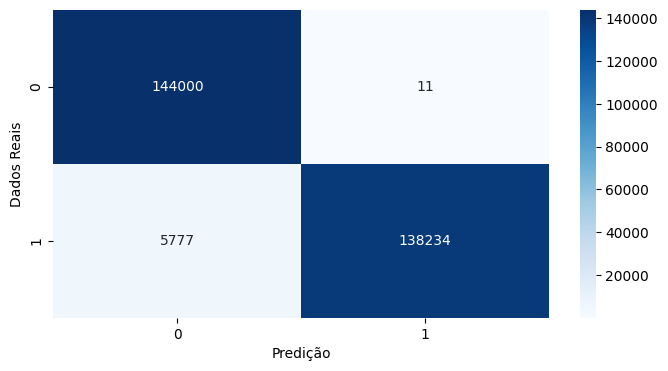

In [ ]:
# Mostra detalhadamente onde o modelo erra e acerta (verdadeiros/falsos positivos e negativos).

cm = confusion_matrix(y_best_train, best_predictions)
print("matriz de confusão:")

plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predição")
plt.ylabel("Dados Reais")

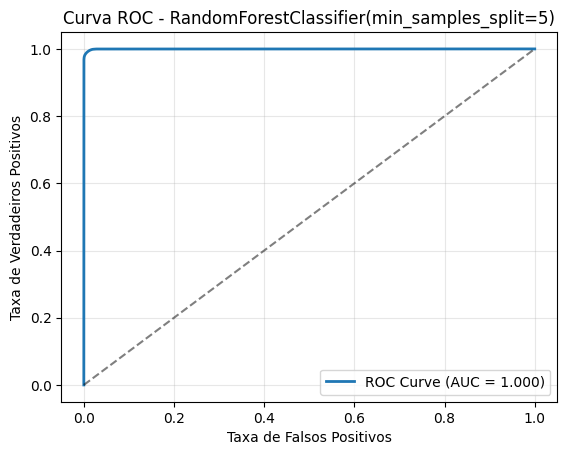

In [57]:
fpr, tpr, _ = roc_curve(y_best_train, best_probabilities)

plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {best_model_info["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title(f'Curva ROC - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)

### Considerações